## Import all required libraries


In [36]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from random import randint
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.layers.core import  Lambda, Dense, Flatten
from keras.callbacks import EarlyStopping
from keras.layers import GlobalAveragePooling2D, Dropout, Convolution2D , MaxPooling2D, InputLayer, Resizing
from keras.applications.vgg16 import preprocess_input

## Load Train and test data

In [37]:
fashion_mnist = keras.datasets.fashion_mnist
(train_full_X, train_full_y), (test_X, test_y) = fashion_mnist.load_data()

#expand 1 more dimention as 1 for colour channel gray
train_full_X = train_full_X.reshape(train_full_X.shape[0], 28, 28,1)
test_X = test_X.reshape(test_X.shape[0], 28, 28,1)

# Convert the images into 3 channels
train_full_X = np.repeat(train_full_X, 3, axis=3)
test_X = np.repeat(test_X, 3, axis=3)


## Visualize the data

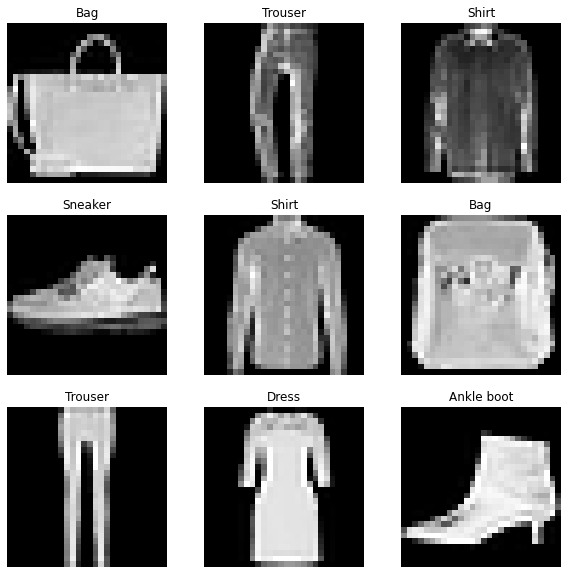

In [38]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", 
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    j = randint(0, 60000)
    plt.imshow(train_full_X[j,].astype("uint8"))
    plt.title(class_names[train_full_y[j,]])
    plt.axis("off")

## Concatenate the train and test data

In [39]:
X = np.concatenate((train_full_X, test_X), axis=0)

X.shape

(70000, 28, 28, 3)

## Designing Convolutional Neural Network Architecture

Import pretrained model VGG16

In [ ]:
vgg = keras.applications.vgg16.VGG16(weights="imagenet", include_top=False, input_shape=(224,224,3))
vgg.trainable = False

Build the model

In [ ]:
base = Sequential([
    InputLayer(input_shape=(28,28,3)),
    Resizing(224, 224, interpolation="bilinear"),
    vgg,
])

base.summary()

features = base.predict(preprocess_input(X))

In [40]:
# save the features
np.save("my_base_VGG16", features)
#features = np.load("my_base_VGG16.npy")

In [41]:
train_full_X= np.array(features[:60000,])
test_X= np.array(features[60000:,])

In [42]:
model = Sequential([
    InputLayer(input_shape=(7, 7, 512)),
    Flatten(),
    Dense(100, activation='relu'),
    Dense(10, activation='softmax'),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 100)               2508900   
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
Total params: 2,509,910
Trainable params: 2,509,910
Non-trainable params: 0
_________________________________________________________________


Compile network

In [43]:
optimizer = keras.optimizers.Adam(learning_rate=1e-6)
model.compile(optimizer=optimizer,
 loss='sparse_categorical_crossentropy',
 metrics=['accuracy'])

Split the data

In [44]:
train_X, val_X, train_y, val_y = train_test_split(train_full_X, train_full_y, test_size=0.10, random_state=42)

Run the model

In [45]:
early_stopping = EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)
history = model.fit(
    train_X, train_y,
    validation_data=(val_X, val_y),
    batch_size=128,
    epochs=100, 
    callbacks=[early_stopping],verbose=1)

Epoch 1/100
422/422 [==============================] - 38s 81ms/step - loss: 4.3277 - accuracy: 0.3740 - val_loss: 2.2483 - val_accuracy: 0.5697
Epoch 2/100
422/422 [==============================] - 16s 38ms/step - loss: 1.7609 - accuracy: 0.6487 - val_loss: 1.4186 - val_accuracy: 0.7122
Epoch 3/100
422/422 [==============================] - 17s 40ms/step - loss: 1.2591 - accuracy: 0.7361 - val_loss: 1.1261 - val_accuracy: 0.7625
Epoch 4/100
422/422 [==============================] - 18s 42ms/step - loss: 1.0272 - accuracy: 0.7761 - val_loss: 0.9634 - val_accuracy: 0.7940
Epoch 5/100
422/422 [==============================] - 18s 43ms/step - loss: 0.8835 - accuracy: 0.8017 - val_loss: 0.8579 - val_accuracy: 0.8087
Epoch 6/100
422/422 [==============================] - 17s 40ms/step - loss: 0.7818 - accuracy: 0.8184 - val_loss: 0.7775 - val_accuracy: 0.8240
Epoch 7/100
422/422 [==============================] - 16s 37ms/step - loss: 0.7047 - accuracy: 0.8300 - val_loss: 0.7179 - val_ac

<AxesSubplot:title={'center':'Accuracy'}>

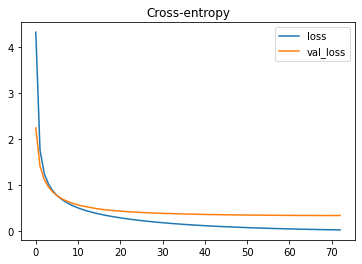

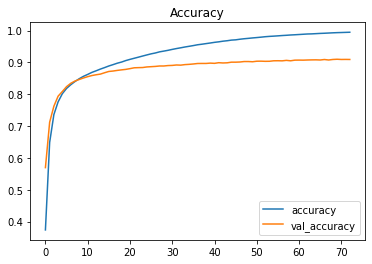

In [50]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title="Accuracy")

Evaluation

In [51]:
model.evaluate(test_X, test_y)

313/313 [==============================] - 1s 3ms/step - loss: 0.3842 - accuracy: 0.8988


[0.3841693699359894, 0.8988000154495239]